In [16]:
# Importando pacotes utilizados no projeto.

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

## Imputar valores ausentes
from sklearn.impute import SimpleImputer

## Codificação numérica as variáveis qualitativas
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

## Normalização/Padronização 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Tranformação de forma 
from sklearn.preprocessing import PowerTransformer

## Pipelines 
import sklearn
#from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer 
sklearn.set_config(enable_metadata_routing=True)

## Tratamento de outliers 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

## Algoritmos 
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)

### Trazendo os dados 

In [7]:
df = pd.read_csv('https://codefinity-content-media.s3.eu-west-1.amazonaws.com/a65bbc96-309e-4df9-a790-a1eb8c815a1c/exams.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group D,associate's degree,standard,none,79,78,72
1,male,group C,some high school,standard,completed,81,73,71
2,female,group D,some high school,free/reduced,none,68,75,79
3,male,group D,some high school,standard,none,66,49,46
4,male,group C,some college,standard,completed,65,67,66


In [8]:
df.shape

(100, 8)

### Verificando os dados 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       100 non-null    object
 1   race/ethnicity               100 non-null    object
 2   parental level of education  100 non-null    object
 3   lunch                        100 non-null    object
 4   test preparation course      100 non-null    object
 5   math score                   100 non-null    int64 
 6   reading score                100 non-null    int64 
 7   writing score                100 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 6.4+ KB


In [10]:
df.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
math score,100.0,67.6,16.5,26.0,55.0,68.0,80.0,100.0
reading score,100.0,70.1,16.7,22.0,61.8,73.0,81.0,100.0
writing score,100.0,68.0,17.1,22.0,60.0,71.0,79.2,100.0


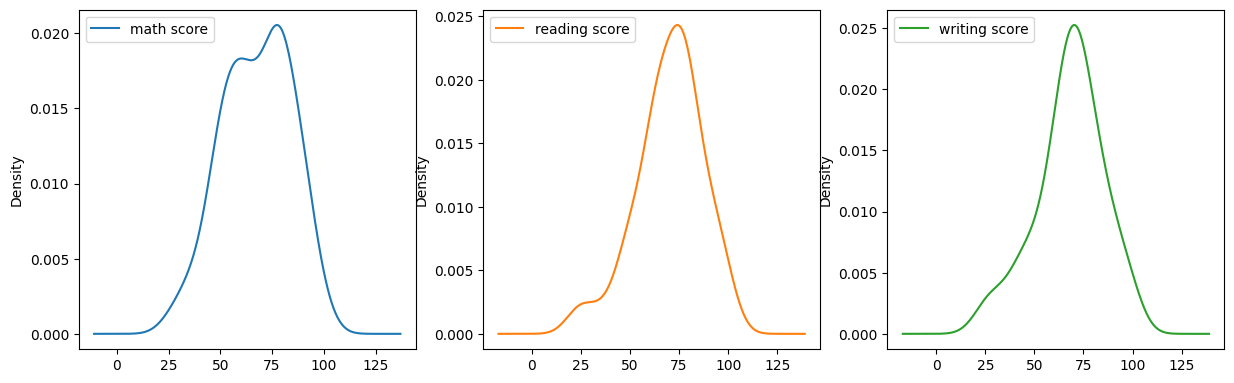

In [11]:
# O density plot facilita a visualização da distribuição dos dados.
df.plot(kind = 'density', figsize = (20,15), layout = (3, 4), subplots = True, sharex = False)
plt.show()

In [13]:
# Assimetria - normal --> 0 
pd.DataFrame(df[['math score', 'reading score', 'writing score']].skew(skipna=False) , columns = ['Assimetria']) 

,Assimetria
math score,-0.249675
reading score,-0.626664
writing score,-0.519681


In [14]:
# Curtose - normal --> 0 
pd.DataFrame(df[['math score', 'reading score', 'writing score']].kurt(skipna=False) , columns = ['Curtose']) 

,Curtose
math score,-0.616054
reading score,0.499314
writing score,0.196800


### Montando o pipeline de tranformação e agrupamento 

In [17]:
class LOFOutlierRemover(BaseEstimator, TransformerMixin):
    """
    A custom transformer to detect and remove outliers using LocalOutlierFactor.
    """
    def __init__(self, n_neighbors=20, contamination='auto', threshold_q=0.05):
        """
        Initializes the LOFOutlierRemover.
        
        Args:
            n_neighbors (int): The number of neighbors to consider for LOF.
            contamination (float or 'auto'): The proportion of outliers in the dataset.
            threshold_q (float): The quantile to determine the outlier threshold.
        """
        self.n_neighbors = n_neighbors
        self.contamination = contamination
        self.threshold_q = threshold_q
        self.lof_ = LocalOutlierFactor(
            n_neighbors=self.n_neighbors, 
            contamination=self.contamination,
            novelty=False
        )
        self.threshold_ = None

    def fit(self, X, y=None):
        """
        Fits the LOF model and determines the outlier threshold.
        """
        self.lof_.fit(X)
        # Determine a threshold for outlier scores
        negative_outlier_factors = self.lof_.negative_outlier_factor_
        self.threshold_ = np.quantile(negative_outlier_factors, self.threshold_q)
        return self

    def transform(self, X):
        """
        Filters out outliers from the dataset.
        """
        negative_outlier_factors = self.lof_.negative_outlier_factor_
        is_inlier = negative_outlier_factors > self.threshold_
        return X[is_inlier]

In [ ]:
# 1) Imputação de valores ausentes 
# 2) Padronização dos dados/Ajuste de forma e Codificação de categóricas (OneHotEncoder) 
# 3) Remoção de Outliers
# 4) Modelagem de grupos 
 
modelo = KMeans(n_clusters=2, random_state=0, n_init="auto")

continua = ['math score', 'reading score', 'writing score']
categorica = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

pipeline_cont = make_pipeline(SimpleImputer(missing_values = np.nan, strategy = 'median'), 
                                   StandardScaler(), 
                                   PowerTransformer())

pipeline_cat = make_pipeline(SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'), OneHotEncoder())
                                     
ct = make_column_transformer((pipeline_cont, continua),
                               (pipeline_cat, categorica), 
                               remainder = 'passthrough')

pipe = make_pipeline(ct, LOFOutlierRemover(contamination='auto'), modelo, verbose = False)

pipe.fit(df)
y_pred = pipe.predict(df)

In [37]:
# After fitting the pipeline
fitted_model = pipe.named_steps['kmeans']
print(fitted_model.n_features_in_) 

20


In [39]:
feature_names = ct.get_feature_names_out()
transformed_data_array = ct.transform(df)
transformed_df = pd.DataFrame(transformed_data_array, columns=feature_names)
transformed_df.head()

,pipeline-1__math score,pipeline-1__reading score,pipeline-1__writing score,pipeline-2__gender_female,pipeline-2__gender_male,pipeline-2__race/ethnicity_group A,pipeline-2__race/ethnicity_group B,pipeline-2__race/ethnicity_group C,pipeline-2__race/ethnicity_group D,pipeline-2__race/ethnicity_group E,pipeline-2__parental level of education_associate's degree,pipeline-2__parental level of education_bachelor's degree,pipeline-2__parental level of education_high school,pipeline-2__parental level of education_master's degree,pipeline-2__parental level of education_some college,pipeline-2__parental level of education_some high school,pipeline-2__lunch_free/reduced,pipeline-2__lunch_standard,pipeline-2__test preparation course_completed,pipeline-2__test preparation course_none
0,0.666829,0.403399,0.143794,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.801761,0.065587,0.080698,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,-0.041732,0.197610,0.608904,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,-0.163240,-1.232345,-1.249330,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,-0.223100,-0.303061,-0.220401,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [42]:
# Dados transformados no novo espaço pelo Kmeans 
data = pd.DataFrame(pipe.fit_transform(df))
data.head()

,0,1
0,2.570174,1.646475
1,2.627840,1.808212
2,2.372817,2.163024
3,1.805454,3.238824
4,2.014218,2.284509


In [43]:
pipe.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline-1',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('standardscaler',
                                                   StandardScaler()),
                                                  ('powertransformer',
                                                   PowerTransformer())]),
                                  ['math score', 'reading score',
                                   'writing score']),
                                 ('pipeline-2',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehotencoder',
                                                   O